In [1]:
import guardrails as gd
import openai
from rich import print as rprint
import tiktoken
import dotenv
import os
import pandas as pd

from app.database import Database, db_config

from app.guardrails_specs.specs import rail_str

dotenv.load_dotenv()
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPEN_API_KEY


## Checking if basic guardrails calls work

In [ ]:
# Create a Guard class
guard = gd.Guard.from_rail_string(rail_str)

test_transaction = '''
Date
	
Transaction Description
	
Debit
	
Credit
	Balance
Jul 22, 2023	AMZ*Sleepsheep Direct		$141.75	$4,838.90
Jul 22, 2023	FIVE GUYS BURGERS & FR	$71.12		$4,980.65
Jul 22, 2023	ABC*ANYTIME FITNESS	$28.34		$4,909.53
Jul 21, 2023	RING MULTICAM MTH PLAN	$15.75		$4,881.19
Jul 19, 2023	DOORDASH*LUNA MEXICAN	$130.82		$4,865.44
Jul 18, 2023	PAYMENT - THANK YOU		$300.00	$4,734.62
Jul 16, 2023	SOLARA RESORT AND SPA	$63.00		$5,034.62
Jul 16, 2023	EDMONTO*3CINTEGRA PARKI	$87.00		$4,971.62
Jul 16, 2023	AMZN Mktp CA*TU5VJ3VX3	$16.73		$4,884.62
Jul 16, 2023	Amazon.ca*J29G10HJ3	$123.90		$4,867.89
Jul 16, 2023	ENTERPRISE CANADA C5E2	$428.22		$4,743.99
'''

# Wrap openai API call

raw_llm_output, guardrail_output = guard(
    openai.ChatCompletion.create,
    prompt_params={"transaction_string": test_transaction},
    
    model="gpt-3.5-turbo",
    max_tokens=2000,
    temperature=0.0,
    num_reasks=0,
)

rprint(guardrail_output)


## Testing with the AI Assistant

### Bare bones test

In [ ]:
database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)
df.head()

In [ ]:
# creating the specs for the guardrails

rail_fin = """
<rail version="0.1">

<output>
    <object name="financial_answer">
        <string name="explanation"/>
        <pythoncode
            name="python_code"
            format="bug-free-python"
            on-fail-bug-free-python="reask"
        />
    </object>
</output>

<instructions>
You are a smart financial assitant that knows how to code in Python. You can provide explanations for your rationale and also provide the code to back it up.

@json_suffix_prompt_examples
</instructions>


<prompt>
You have at your disposal a pandas dataframe called `df` that contains the following columns:

- transaction_date: The date of the transaction
- transaction_description: The description of the transaction
- amount: The amount of money debited from the account
- category: The category of the transaction. 


Given the financial question below, provide a list of explanations and possible queries to back you up.

Financial Question:
{{financial_question}}

@complete_json_suffix</prompt>

</rail>
"""

rail_fin2 = """
<rail version="0.1">

<output>
    <object name="financial_answer">
        <string name="explanation_string"/>
        <pythoncode
            name="python_code"
            format="bug-free-python"
        />
    </object>
</output>

<instructions>
You are a smart financial assitant that knows how to code in Python. You can provide explanations for your rationale and also provide the code to back it up.

@json_suffix_prompt_examples
</instructions>


<prompt>
You have at your disposal a pandas dataframe called `df` that contains the following columns:

- transaction_date: The date of the transaction
- transaction_description: The description of the transaction
- amount: The amount of money debited from the account
- category: The category of the transaction. 

Generate a list of explanations and the string to be completed in the financial question below. specify what are the variables you need to complete the string.

Financial Question:
{{financial_question}}

@complete_json_suffix</prompt>

</rail>
"""

In [ ]:
guard = gd.Guard.from_rail_string(rail_fin2)

financial_question = """
How much did I spend on groceries in the last 3 months?
"""

raw_llm_response, validated_response = guard(
    openai.ChatCompletion.create,
    prompt_params={"financial_question": financial_question},
    model="gpt-3.5-turbo",
    max_tokens=3000,
    temperature=0,
)


In [ ]:
rprint(validated_response)

In [ ]:
rprint(raw_llm_response)

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
groceries_df = df[(df['category'] == 'groceries') & (df['transaction_date'] >= pd.Timestamp.now() - pd.DateOffset(months=3))]
total_spent = groceries_df['amount'].sum()
total_spent

### Testing pandas ai

#### Random test

In [2]:
from pandasai import PandasAI


database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)
df.head()

2023-08-13 13:07:22,072 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-08-13 13:07:22,073 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-13 13:07:22,077 INFO sqlalchemy.engine.Engine select current_schema()
2023-08-13 13:07:22,077 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-13 13:07:22,080 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-08-13 13:07:22,080 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-08-13 13:07:22,082 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-08-13 13:07:22,083 INFO sqlalchemy.engine.Engine SELECT llm_finances.transactions.transaction_id AS llm_finances_transactions_transaction_id, llm_finances.transactions.transaction_date AS llm_finances_transactions_transaction_date, llm_finances.transactions.transaction_description AS llm_finances_transactions_transaction_description, llm_finances.transactions.credit AS llm_finances_transactions_credit, llm_finances.transactions.debit AS llm_finances_transactions_debit, ll

/Users/fernandomeira/projects/LLM-budget-assistant/app/database.py:219: SAWarning: relationship 'User.user_accounts' will copy column users.user_id to column accounts.user_id, which conflicts with relationship(s): 'Account.users' (copies users.user_id to accounts.user_id), 'User.accounts' (copies users.user_id to accounts.user_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="accounts,users"' to the 'User.user_accounts' relationship. (Background on this warning at: https://sqlalche.me/e/20/qzyx) (This warning originated from the `configure_mappers()` process, which was invoked automatically in response to a user-initiated operat

,transaction_id,transaction_date,transaction_description,credit,amount,account_id,category_id,user_id,category
0,237,2023-01-01,"FIVE GUYS BURGERS & FR, 780-436-9885",0.0,46.66,4,17,3,Takeout
1,234,2023-01-02,"SAVE ON FOODS #6622, EDMONTON",0.0,30.31,4,24,3,Grocery
2,236,2023-01-02,"DOLLARAMA #1101, EDMONTON",0.0,46.28,4,30,3,Home Goods
3,235,2023-01-02,"MCDONALD'S #40413, EDMONTON",0.0,8.38,4,17,3,Takeout
4,231,2023-01-06,"PC EXPRESS 1549, EDMONTON",0.0,97.90,4,24,3,Grocery


In [ ]:
from pandasai import PandasAI

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=OPEN_API_KEY)

pandas_ai = PandasAI(llm)
rprint(pandas_ai(df, prompt='plot for me my grocery spending monthly'))

In [ ]:
rprint(pandas_ai(df, prompt='Give me some tips on how to save 10% of all my spending monthly'))

#### Chaining it with Langchain

In [ ]:
from pandasai import PandasAI


database = Database(**db_config)

test_user_id = 3

def convert_transactions_to_dataframe(user_id: int):
    transactions = database.get_all_transactions_by_user_id(user_id=user_id)
    df = pd.DataFrame(
        [
            {
                "transaction_id": transaction.transaction_id,
                "transaction_date": transaction.transaction_date,
                "transaction_description": transaction.transaction_description,
                "credit": transaction.credit,
                "amount": transaction.debit,
                "account_id": transaction.account_id,
                "category_id": transaction.category_id,
                "user_id": transaction.user_id,
                "category": category.category_name,
            }
            for transaction, category in transactions
        ]
    )

    return df

# converting transactions to a dataframe
df = convert_transactions_to_dataframe(test_user_id)


from pandasai import PandasAI

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=OPEN_API_KEY)

pandas_ai = PandasAI(llm)
# rprint(pandas_ai(df, prompt='plot for me my grocery spending monthly'))

#### Using the pandas ai base prompt

In [ ]:
from pandasai.helpers.anonymizer import anonymize_dataframe_head

from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

# generating reference data for the dataframe

df_ref = {
    'df_head': anonymize_dataframe_head(df),
    'num_rows': df.shape[0],
    'num_columns': df.shape[1],
}


# Taking the idea from pandas-ai, we can pass the dataframe data to the first prompt and ask it to generate a generic pandas call

initial_prompt = """
    You are provided with a pandas dataframe (df) with {num_rows} rows and {num_columns} columns.
    This is the metadata of the dataframe:
    {df_head}.

    You will be given a question that needs to be answered with the data above. Generate a JSON object with the following attributes:

    - next step: can this be solved with a single pandas call? (yes/no)
    - pandas call: if yes, what is the pandas call that solves this question?
    - pandas call explanation: if yes, explain how this pandas call solves the question

    question: {question}
"""


human_message_prompt = HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            template=initial_prompt,
            input_variables=["num_rows", "num_columns", "df_head", "question"],
        )
    )
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])
chat = ChatOpenAI(temperature=0)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)
print(chain.run(**df_ref, question="If I want to spend less, what category should I cut down on? and by how much?"))




#### Trying to be more general and make the model think

In [ ]:
from pandasai.helpers.anonymizer import anonymize_dataframe_head

from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

# generating reference data for the dataframe

# df_ref = {
#     'df_head': anonymize_dataframe_head(df),
#     'num_rows': df.shape[0],
#     'num_columns': df.shape[1],
# }

df_ref = {
    "df_columns" : ', '.join(anonymize_dataframe_head(df).columns),
    "spending_categories" : ', '.join(df['category'].unique()),
}


# Taking the idea from pandas-ai, we can pass the dataframe data to the first prompt and ask it to generate a generic pandas call

initial_prompt = """
    You are provided with a set of variables that describe how a person spend their money, the variables are:
    
    variables: {df_columns}
    spending categories: {spending_categories}

    You will be given a question that needs to be answered with the variables above. Generate a JSON object with the following attributes:

    - information_needed: a description of the information you need to answer the question
    - answer: if you have everything you need provide the final answer to the question, if not write False


    question: {question}
"""


human_message_prompt = HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            template=initial_prompt,
            input_variables=["df_columns", "spending_categories", "question"],
        )
    )
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])
chat = ChatOpenAI(temperature=0)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)
print(chain.run(**df_ref, question="If I want to spend less, what category should I cut down on? and by how much?"))




#### Trying to not use LangChain

In [79]:
# creating a simple class to incorporate history
# using OpenAI's API
from pandasai import PandasAI
from pandasai.llm.openai import OpenAI
import openai
import re


class LLM:
    def __init__(self, model:str, model_instruction:str=None, save_chat_history:bool=True):
        self.model = model
        self.llm = OpenAI(api_token=OPEN_API_KEY)
        self.pandas_ai = PandasAI(llm=self.llm, conversational=True, save_charts=True, save_charts_path="charts")
        self.chat_history = []
        self.save_chat_history = save_chat_history

        if model_instruction is None:
            self.model_instruction = "You are a helpful assistant."
        else:
            self.model_instruction = model_instruction
        
        self.chat_history.append({"role": "system", "content": self.model_instruction})    
        

    def ask(self, question:str):
        self.chat_history.append({"role": "user", "content": question})
        response = openai.ChatCompletion.create(
            model=self.model,
            messages=self.chat_history,
            temperature=0
        )

        if self.save_chat_history:
            self.chat_history.append({"role": "system", "content": response['choices'][0]['message']['content']})

        return response

    def ask_with_pandasai(self, dataframe: pd.DataFrame, question:str):
        response = self.pandas_ai(dataframe, prompt=question)

        return response
    
    def extract_plot_path_from_call(self, code_call:str):
        match = re.search(r"savefig\('(.*?)'\)", code_call)
        if match:
            return match.group(1) 
        else:
            print("No matching content found.")


In [80]:
from pandasai.helpers.anonymizer import anonymize_dataframe_head

df_ref = {
    "df_columns" : ', '.join(anonymize_dataframe_head(df).columns),
    # "spending_categories" : ', '.join(df['category'].unique()),
}


# Taking the idea from pandas-ai, we can pass the dataframe data to the first prompt and ask it to generate a generic pandas call

initial_prompt = """
    You will be given a financial question and a dataframe with the following columns: {df_columns}

    Your goal is to analyze this question and provide the following object as output:

   
        is_valid: if the question can be answered by querying the dataframe return True, otherwise False.
        question: if is_valid=True, return the question as is, otherwise request the user to rephrase the question.
        objective_question: if is_valid=True, convert the question into a request.
        answer: if is_valid=False, provide your a followup answer to help the user rephrase the question, otherwise return None.


    question: {question}
"""

model_instruction = "You are an expert in responding financial questions. Never provide fake information. Output only valid JSON."


llm = LLM(model="gpt-3.5-turbo", model_instruction=model_instruction)

rprint(llm.ask(question=initial_prompt.format(**df_ref, question="How can I save 10% every month?"))['choices'][0]['message']['content'])


{
  "is_valid": true,
  "question": "How can I save 10% every month?",
  "objective_question": "What are some strategies to save 10% of my income every month?",
  "answer": null
}

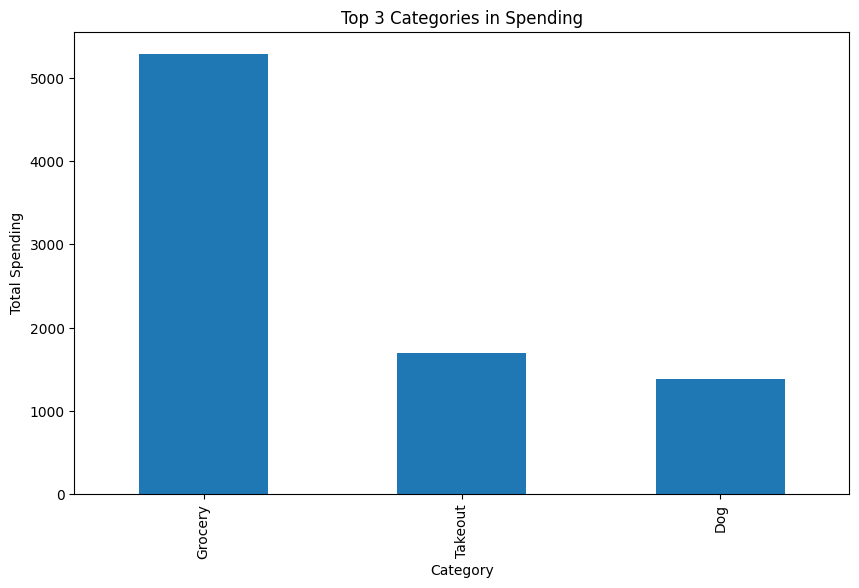

Charts saving to: charts/exports/charts/7955d514-44c2-4a98-8277-66ad0f75c87a
Based on your spending, the top 3 categories are grocery, takeout, and dog expenses. You have spent $5293.72 on groceries, $1690.07 on takeout, and $1379.27 on your dog.


In [81]:
print(llm.ask_with_pandasai(df, question='What are the top 3 categories in my spending? Please provide me a text and a plot.'))

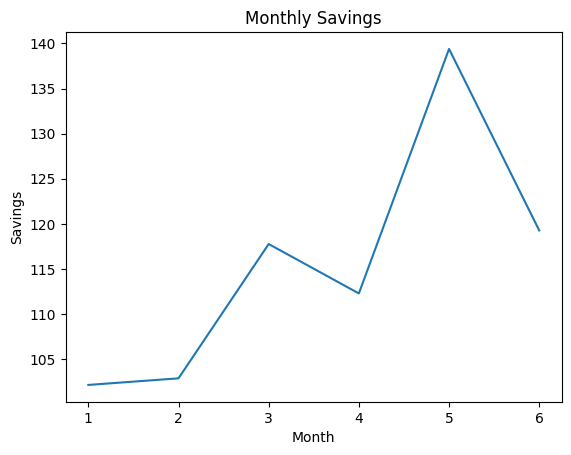

Charts saving to: charts/exports/charts/56bbb321-042e-4b3f-9316-8de2735ae957


str

In [83]:
x = llm.ask_with_pandasai(df, question='How can I save 5% of my spending every month? Please provide me a text and a plot.')

type(x)

In [85]:
llm.pandas_ai.last_code_executed

"df['transaction_date'] = pd.to_datetime(df['transaction_date'])\ndf['month'] = df['transaction_date'].dt.month\nmonthly_spending = df.groupby('month')['amount'].sum()\nsavings = monthly_spending * 0.05\ntext = 'To save 5% of your spending every month, you should save ${:.2f}.'.format(savings.mean())\nprint(text)\nplt.plot(savings)\nplt.xlabel('Month')\nplt.ylabel('Savings')\nplt.title('Monthly Savings')\nplt.savefig('charts/exports/charts/56bbb321-042e-4b3f-9316-8de2735ae957/chart.png')\nplt.show(block=False)\nplt.close('all')"